In [2]:
!pip install pandas numpy scikit-learn matplotlib

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/COEN498-691-PROJECT/ML_project/main/data/processed/COEN498-691_HAR_preprocessed_dataset.csv"
data = pd.read_csv(url)

print("Data loaded successfully!")
print(data.shape)
data.head()

Data loaded successfully!
(4751, 39)


,ax_mean,ax_std,ax_max,ax_min,ax_range,ax_skew,ax_kurt,ax_zcr,ay_mean,ay_std,...,ayG_mean,azG_mean,Gx,Gy,Gz,Gx_angle,Gy_angle,Gz_angle,activity_id,participant_id
0,-0.002040,0.007937,0.013687,-0.024382,0.038069,-0.428371,1.735067,0,0.000018,0.003702,...,-1.023843,0.187873,0.065561,-0.981462,0.180096,1.505189,2.948741,1.389712,1,LL
1,0.004890,0.009201,0.032755,-0.011421,0.044177,1.177575,2.846603,0,0.001896,0.004891,...,-1.023652,0.190706,0.069292,-0.980722,0.182708,1.501449,2.944921,1.387056,1,LL
2,-0.010652,0.043875,0.070725,-0.110145,0.180870,-0.535210,0.442954,6,-0.003511,0.019515,...,-1.023306,0.193795,0.073180,-0.979901,0.185575,1.497551,2.940762,1.384139,1,LL
3,-0.006527,0.066108,0.150761,-0.110145,0.260906,0.463284,-0.030079,9,0.000702,0.028293,...,-1.022801,0.197092,0.077102,-0.979012,0.188654,1.493618,2.936354,1.381005,1,LL
4,0.009423,0.055730,0.150761,-0.108607,0.259368,0.306438,0.663858,8,0.002152,0.026648,...,-1.022139,0.200553,0.080937,-0.978070,0.191906,1.489771,2.931781,1.377692,1,LL


In [4]:
# ===== 2. Explore the Dataset =====
# In this part, we look at the dataset to understand what kind of data we have,
# check for missing values, and see how the activities are distributed.
# This also helps us find the correct name of the target column.

print("Dataset Info:")
data.info()

print("\nMissing values in the dataset:", data.isnull().sum().sum())

print("\nActivity distribution in the dataset:")
display(data['activity_id'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4751 entries, 0 to 4750
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ax_mean         4751 non-null   float64
 1   ax_std          4751 non-null   float64
 2   ax_max          4751 non-null   float64
 3   ax_min          4751 non-null   float64
 4   ax_range        4751 non-null   float64
 5   ax_skew         4751 non-null   float64
 6   ax_kurt         4751 non-null   float64
 7   ax_zcr          4751 non-null   int64  
 8   ay_mean         4751 non-null   float64
 9   ay_std          4751 non-null   float64
 10  ay_max          4751 non-null   float64
 11  ay_min          4751 non-null   float64
 12  ay_range        4751 non-null   float64
 13  ay_skew         4751 non-null   float64
 14  ay_kurt         4751 non-null   float64
 15  ay_zcr          4751 non-null   int64  
 16  az_mean         4751 non-null   float64
 17  az_std          475

,count
activity_id,
1,1205
4,1196
3,1184
2,1166


In [5]:
# ===== 3. Prepare the Data =====
# In this part, we separate the features (X) and the target (y),
# split the dataset into training and testing sets,
# and then prepare everything for the model.

from sklearn.model_selection import train_test_split

# The target column (label)
target_col = "activity_id"

# All numeric features except the target column
X = data.select_dtypes(include=["number"]).drop(columns=[target_col])
y = data[target_col]

# Split the data by participant_id to avoid overlap
from sklearn.model_selection import GroupShuffleSplit

groups = data["participant_id"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Check if any participant appears in both sets
train_people = set(groups.iloc[train_idx])
test_people = set(groups.iloc[test_idx])
print("People overlap?", not train_people.isdisjoint(test_people))


print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Number of classes:", y.nunique())
print("Class labels:", y.unique())

Train shape: (3801, 37)
Test shape: (950, 37)
People overlap? False
Training set shape: (3801, 37)
Testing set shape: (950, 37)
Number of classes: 4
Class labels: [1 2 3 4]


In [6]:
# ===== SVM Model: Baseline Training and Evaluation =====

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline: scaling + SVM classifier (RBF kernel)
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

# GroupKFold CV (same idea as for Logistic Regression)
groups = data["participant_id"]
gkf = GroupKFold(n_splits=5)

svm_cv_scores = cross_validate(
    svm_pipe,
    X,
    y,
    groups=groups,
    cv=gkf,
    scoring=["accuracy", "f1_macro"],
    n_jobs=-1
)

print(f"SVM CV Accuracy: {svm_cv_scores['test_accuracy'].mean():.3f} ± {svm_cv_scores['test_accuracy'].std():.3f}")
print(f"SVM CV F1-macro: {svm_cv_scores['test_f1_macro'].mean():.3f} ± {svm_cv_scores['test_f1_macro'].std():.3f}")


SVM CV Accuracy: 0.946 ± 0.098
SVM CV F1-macro: 0.930 ± 0.130


In [9]:
# ===== Metrics Table for SVM (baseline) =====

svm_results_table = pd.DataFrame({
    "CV_acc_mean": [svm_cv_scores["test_accuracy"].mean()],
    "CV_acc_std":  [svm_cv_scores["test_accuracy"].std()],
    "CV_f1_mean":  [svm_cv_scores["test_f1_macro"].mean()],
    "CV_f1_std":   [svm_cv_scores["test_f1_macro"].std()]
})

print("\n📊 SVM Metrics Table (baseline):")
svm_results_table



📊 SVM Metrics Table (baseline):


,CV_acc_mean,CV_acc_std,CV_f1_mean,CV_f1_std
0,0.945632,0.097775,0.929541,0.129922


In [11]:
# ===== Hyperparameter Tuning for SVM (RBF kernel) =====

from sklearn.model_selection import GridSearchCV

svm_tune_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf"))
])

svm_param_grid = {
    "clf__C":     [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.001]
}

gkf = GroupKFold(n_splits=5)

svm_grid = GridSearchCV(
    estimator=svm_tune_pipe,
    param_grid=svm_param_grid,
    cv=gkf,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=False
)

svm_grid.fit(X, y, groups=groups)

print("Best SVM params:", svm_grid.best_params_)
print("Best SVM CV F1-macro:", svm_grid.best_score_)

svm_tuning_results = pd.DataFrame({
    "C":     [p["clf__C"] for p in svm_grid.cv_results_["params"]],
    "gamma": [p["clf__gamma"] for p in svm_grid.cv_results_["params"]],
    "mean_f1": svm_grid.cv_results_["mean_test_score"],
    "std_f1":  svm_grid.cv_results_["std_test_score"]
})

print("\nSVM Hyperparameter tuning results (sorted):")
svm_tuning_results.sort_values("mean_f1", ascending=False)


Best SVM params: {'clf__C': 10, 'clf__gamma': 0.01}
Best SVM CV F1-macro: 0.9303937879977692

SVM Hyperparameter tuning results (sorted):


,C,gamma,mean_f1,std_f1
7,10.0,0.01,0.930394,0.130261
6,10.0,scale,0.930181,0.130155
3,1.0,scale,0.929541,0.129922
4,1.0,0.01,0.929538,0.130010
8,10.0,0.001,0.929476,0.130103
1,0.1,0.01,0.928689,0.129661
0,0.1,scale,0.928480,0.129475
5,1.0,0.001,0.928422,0.129641
2,0.1,0.001,0.917825,0.122836


SVM Test Accuracy: 0.9957894736842106
SVM Test F1-macro: 0.9957532369170845

SVM Classification Report:
               precision    recall  f1-score   support

           1      0.983     1.000     0.992       236
           2      1.000     0.983     0.991       235
           3      1.000     1.000     1.000       231
           4      1.000     1.000     1.000       248

    accuracy                          0.996       950
   macro avg      0.996     0.996     0.996       950
weighted avg      0.996     0.996     0.996       950



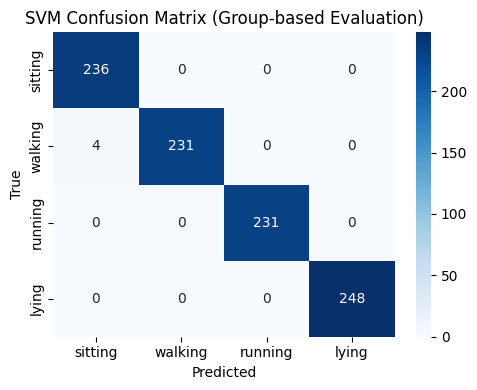

In [13]:
# ===== Final SVM Model with Best Hyperparameters =====

best_svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=10, gamma=0.01))
])

best_svm_pipe.fit(X_train, y_train)
y_svm_pred = best_svm_pipe.predict(X_test)

print("SVM Test Accuracy:", accuracy_score(y_test, y_svm_pred))
print("SVM Test F1-macro:", f1_score(y_test, y_svm_pred, average='macro'))
print("\nSVM Classification Report:\n", classification_report(y_test, y_svm_pred, digits=3))

# Confusion matrix
svm_cm = confusion_matrix(y_test, y_svm_pred, labels=[1,2,3,4])

plt.figure(figsize=(5,4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['sitting','walking','running','lying'],
            yticklabels=['sitting','walking','running','lying'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix (Group-based Evaluation)")
plt.tight_layout()
plt.show()


In [14]:
# ===== SVM Error Analysis =====

svm_mis_mask = y_test != y_svm_pred

svm_errors_df = X_test.copy()
svm_errors_df["true_label"] = y_test.values
svm_errors_df["pred_label"] = y_svm_pred

label_map = {1: "sitting", 2: "walking", 3: "running", 4: "lying"}
svm_errors_df["true_activity"] = svm_errors_df["true_label"].map(label_map)
svm_errors_df["pred_activity"] = svm_errors_df["pred_label"].map(label_map)

print(f"Number of misclassified samples (SVM): {svm_mis_mask.sum()}")
print("\nExamples of misclassified samples (SVM):")
svm_errors_df[svm_mis_mask].head()


Number of misclassified samples (SVM): 4

Examples of misclassified samples (SVM):


,ax_mean,ax_std,ax_max,ax_min,ax_range,ax_skew,ax_kurt,ax_zcr,ay_mean,ay_std,...,Gx,Gy,Gz,Gx_angle,Gy_angle,Gz_angle,true_label,pred_label,true_activity,pred_activity
1216,-0.015652,0.067444,0.098969,-0.133997,0.232966,0.119439,-0.876987,8,0.028781,0.111936,...,-0.030796,-0.987942,0.151728,1.601597,2.986146,1.418480,2,1,walking,sitting
1282,0.021929,0.110255,0.308232,-0.189938,0.498170,0.581304,0.902062,7,0.025614,0.136419,...,-0.045516,-0.986953,0.154442,1.616328,2.979879,1.415734,2,1,walking,sitting
1303,-0.025303,0.063767,0.116806,-0.164518,0.281324,-0.230880,0.319322,6,-0.003952,0.117315,...,-0.052945,-0.989854,0.131852,1.623767,2.999025,1.438559,2,1,walking,sitting
1384,0.000549,0.085491,0.239133,-0.123624,0.362757,1.130239,1.334812,5,0.028687,0.123847,...,-0.030700,-0.988480,0.148206,1.601502,2.989656,1.422042,2,1,walking,sitting


In [15]:
# ===== SVM: LOSO (Leave-One-Subject-Out) Validation =====

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate

groups = data["participant_id"]  # same as before

logo = LeaveOneGroupOut()

svm_loso_scores = cross_validate(
    best_svm_pipe,      # tuned SVM: C=10, gamma=0.01  (یا هرچی برای تو بهترین شد)
    X,
    y,
    groups=groups,
    cv=logo,
    scoring=["accuracy", "f1_macro"],
    n_jobs=-1
)

print("SVM LOSO Accuracy (mean):", svm_loso_scores["test_accuracy"].mean())
print("SVM LOSO Accuracy (std): ", svm_loso_scores["test_accuracy"].std())
print("SVM LOSO F1-macro (mean):", svm_loso_scores["test_f1_macro"].mean())
print("SVM LOSO F1-macro (std): ", svm_loso_scores["test_f1_macro"].std())


SVM LOSO Accuracy (mean): 0.9464896275597916
SVM LOSO Accuracy (std):  0.09808629501960012
SVM LOSO F1-macro (mean): 0.9303937879977692
SVM LOSO F1-macro (std):  0.13026070310932192


In [16]:
import pandas as pd

svm_loso_table = pd.DataFrame({
    "fold": range(len(svm_loso_scores["test_accuracy"])),
    "acc":  svm_loso_scores["test_accuracy"],
    "f1":   svm_loso_scores["test_f1_macro"]
})

svm_loso_table


,fold,acc,f1
0,0,0.987179,0.987233
1,1,0.995789,0.995753
2,2,0.998955,0.998956
3,3,1.000000,1.000000
4,4,0.750524,0.670027
